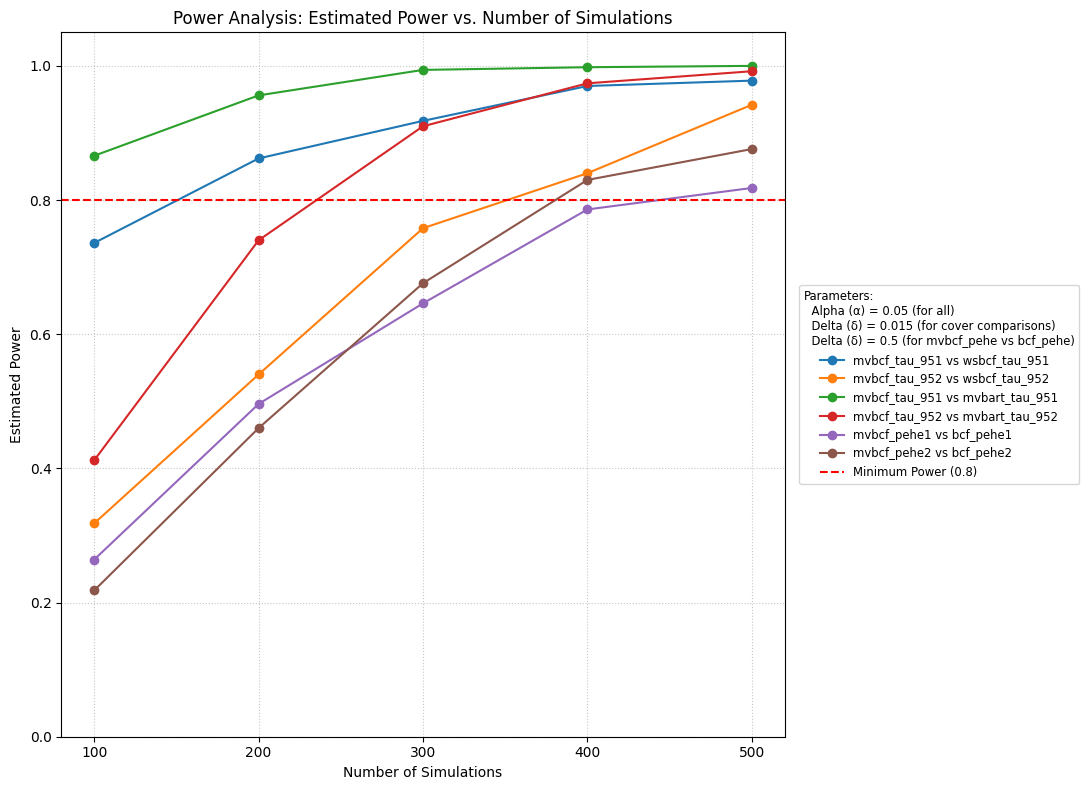

In [1]:
import matplotlib.pyplot as plt
import numpy as np # Optional, but good practice for numerical data

# --- Data ---
simulations = [100, 200, 300, 400, 500]

# Power values for each comparison across simulations
power_data = {
    # Comparison Name: [Power @ 50, Power @ 100, Power @ 200, Power @ 300, Power @ 400, Power @ 500]
    "mvbcf_tau_951 vs wsbcf_tau_951":    [0.736, 0.862, 0.918, 0.970, 0.978], # Delta=0.015 (Note: Assumed 'f_tau_951' at 400 was a typo for 'mvbcf_tau_951')
    "mvbcf_tau_952 vs wsbcf_tau_952":    [0.318, 0.540, 0.758, 0.840, 0.942], # Delta=0.015
    "mvbcf_tau_951 vs mvbart_tau_951":   [0.866, 0.956, 0.994, 0.998, 1.000], # Delta=0.015
    "mvbcf_tau_952 vs mvbart_tau_952":   [0.412, 0.740, 0.910, 0.974, 0.992], # Delta=0.015
    "mvbcf_pehe1 vs bcf_pehe1":        [0.264, 0.496, 0.646, 0.786, 0.818], # Delta=0.5
    "mvbcf_pehe2 vs bcf_pehe2":        [0.218, 0.460, 0.676, 0.830, 0.876]  # Delta=0.5
}

# --- Plotting ---
fig, ax = plt.subplots(figsize=(13, 8)) # Create figure and axes objects, adjust figure size

# Plot power curves for each comparison
for comparison_name, power_values in power_data.items():
    ax.plot(simulations, power_values, marker='o', linestyle='-', label=comparison_name)

# Add the minimum power threshold line
ax.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='Minimum Power (0.8)')

# --- Customize Plot ---
ax.set_xlabel("Number of Simulations")
ax.set_ylabel("Estimated Power")
ax.set_title("Power Analysis: Estimated Power vs. Number of Simulations")
ax.set_ylim(0, 1.05) # Set y-axis limits from 0 to slightly above 1
ax.set_xticks(simulations) # Ensure x-axis ticks are exactly at the simulation counts
ax.grid(True, linestyle=':', alpha=0.7) # Add a light grid for readability

# --- Create Legend ---
# Combine line legend with parameter info
handles, labels = ax.get_legend_handles_labels() # Get handles and labels generated by plot and axhline

# Create the text for the parameters
param_text = ("Parameters:\n"
              "  Alpha (α) = 0.05 (for all)\n"
              "  Delta (δ) = 0.015 (for cover comparisons)\n"
              "  Delta (δ) = 0.5 (for mvbcf_pehe vs bcf_pehe)")

# Add parameter text as a separate anchored text box inside the legend area or nearby
# You might need to adjust the bbox_to_anchor and loc based on your figure size/layout
ax.legend(handles=handles, labels=labels, title=param_text, title_fontsize='small',
          loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0., fontsize='small')

# Adjust layout to prevent legend overlapping plot elements
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust right boundary to make space for legend

# --- Show Plot ---
plt.show()

In [2]:
import pandas as pd
import numpy as np
import io

# --- Original P-values ---
original_p_text = """
mvbcf_tau_951_location_welch   3.404376e-01
mvbcf_tau_952_location_welch   2.276454e-02
mvbcf_pehe1_location_welch    3.877277e-34
mvbcf_pehe2_location_welch    2.359128e-35
mvbart_tau_951_location_welch 1.510069e-09
mvbart_tau_952_location_welch 3.424636e-09
"""

# --- Adjusted P-values ---
adjusted_p_text = """
comparison                       bonferroni          holm            BH
mvbcf_tau_951_location_welch   1.000000e+00  3.404376e-01  3.404376e-01
mvbcf_tau_952_location_welch   1.365872e-01  4.552907e-02  2.731744e-02
mvbcf_pehe1_location_welch    2.326366e-33  1.938638e-33  1.163183e-33
mvbcf_pehe2_location_welch    1.415477e-34  1.415477e-34  1.415477e-34
mvbart_tau_951_location_welch 9.060414e-09  6.040276e-09  3.020138e-09
mvbart_tau_952_location_welch 2.054781e-08  1.027391e-08  5.136954e-09
"""

# --- Significance ---
significance_text = """
comparison                    bonferroni   holm     BH
mvbcf_tau_951_location_welch      FALSE  FALSE  FALSE
mvbcf_tau_952_location_welch      FALSE   TRUE   TRUE
mvbcf_pehe1_location_welch         TRUE   TRUE   TRUE
mvbcf_pehe2_location_welch         TRUE   TRUE   TRUE
mvbart_tau_951_location_welch      TRUE   TRUE   TRUE
mvbart_tau_952_location_welch      TRUE   TRUE   TRUE
"""

# Read data into DataFrames
original_p = pd.read_csv(io.StringIO(original_p_text), sep='\s+', header=None, index_col=0, names=['comparison', 'original_p'])
adjusted_p = pd.read_csv(io.StringIO(adjusted_p_text), sep='\s+', index_col=0)
significance = pd.read_csv(io.StringIO(significance_text), sep='\s+', index_col=0).astype(bool) # Read as boolean

# Clean index names (remove '_location_welch' for brevity in plots if desired)
def clean_name(name):
    return name.replace('_location_welch', '')

original_p.index = original_p.index.map(clean_name)
adjusted_p.index = adjusted_p.index.map(clean_name)
significance.index = significance.index.map(clean_name)

# Combine adjusted p-values and significance for easier plotting
p_val_combined = adjusted_p.melt(ignore_index=False, var_name='method', value_name='adjusted_p').reset_index()
sig_combined = significance.melt(ignore_index=False, var_name='method', value_name='significant').reset_index()

# Merge all data together
results_df = pd.merge(p_val_combined, sig_combined, on=['comparison', 'method'])
results_df = pd.merge(results_df, original_p.reset_index(), on='comparison')

# Add -log10(p-value) for visualization (handle p=0 or very small values)
# Add a small epsilon to avoid log10(0)
epsilon = 1e-300 # A very small number
results_df['neg_log10_p'] = -np.log10(results_df['adjusted_p'] + epsilon)
# Cap the -log10 value if p was truly 0, or adjust epsilon if needed
results_df.loc[results_df['adjusted_p'] == 0, 'neg_log10_p'] = 300 # Set to max value if p was 0

# Significance level line
alpha = 0.05
neg_log10_alpha = -np.log10(alpha)

print("Processed DataFrame Head:")
print(results_df.head())
print(f"\n-log10(alpha=0.05) = {neg_log10_alpha}")

Processed DataFrame Head:
       comparison      method    adjusted_p  significant    original_p  \
0   mvbcf_tau_951  bonferroni  1.000000e+00        False  3.404376e-01   
1   mvbcf_tau_952  bonferroni  1.365872e-01        False  2.276454e-02   
2     mvbcf_pehe1  bonferroni  2.326366e-33         True  3.877277e-34   
3     mvbcf_pehe2  bonferroni  1.415477e-34         True  2.359128e-35   
4  mvbart_tau_951  bonferroni  9.060414e-09         True  1.510069e-09   

   neg_log10_p  
0    -0.000000  
1     0.864590  
2    32.633322  
3    33.849097  
4     8.042852  

-log10(alpha=0.05) = 1.3010299956639813


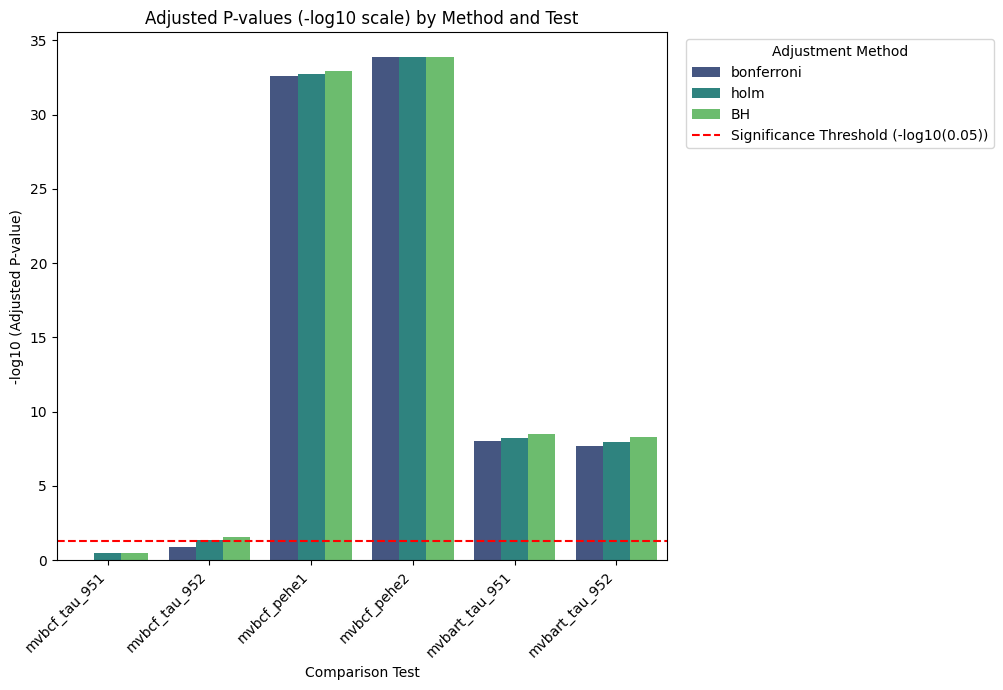

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.barplot(data=results_df, x='comparison', y='neg_log10_p', hue='method', palette='viridis')

# Add significance threshold line
plt.axhline(y=neg_log10_alpha, color='red', linestyle='--', linewidth=1.5, label=f'Significance Threshold (-log10({alpha}))')

plt.xlabel("Comparison Test")
plt.ylabel("-log10 (Adjusted P-value)")
plt.title("Adjusted P-values (-log10 scale) by Method and Test")
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap
plt.legend(title='Adjustment Method', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

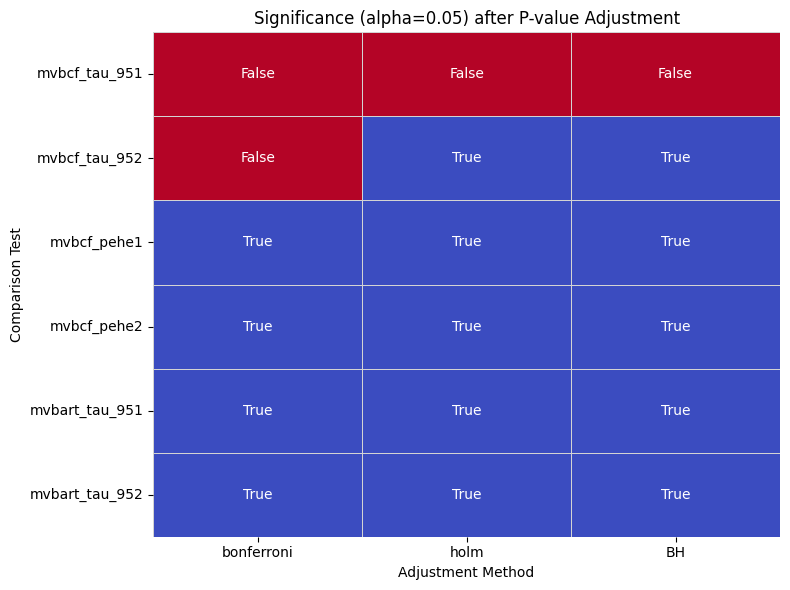

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot the significance data back into a grid format
sig_pivot = significance # Use the boolean DataFrame directly

plt.figure(figsize=(8, 6))
sns.heatmap(sig_pivot, annot=True, cmap='coolwarm_r', fmt='', # annot=True displays TRUE/FALSE
            linewidths=.5, linecolor='lightgray', cbar=False) # Use reversed coolwarm: red=TRUE, blue=FALSE

plt.xlabel("Adjustment Method")
plt.ylabel("Comparison Test")
plt.title(f"Significance (alpha={alpha}) after P-value Adjustment")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

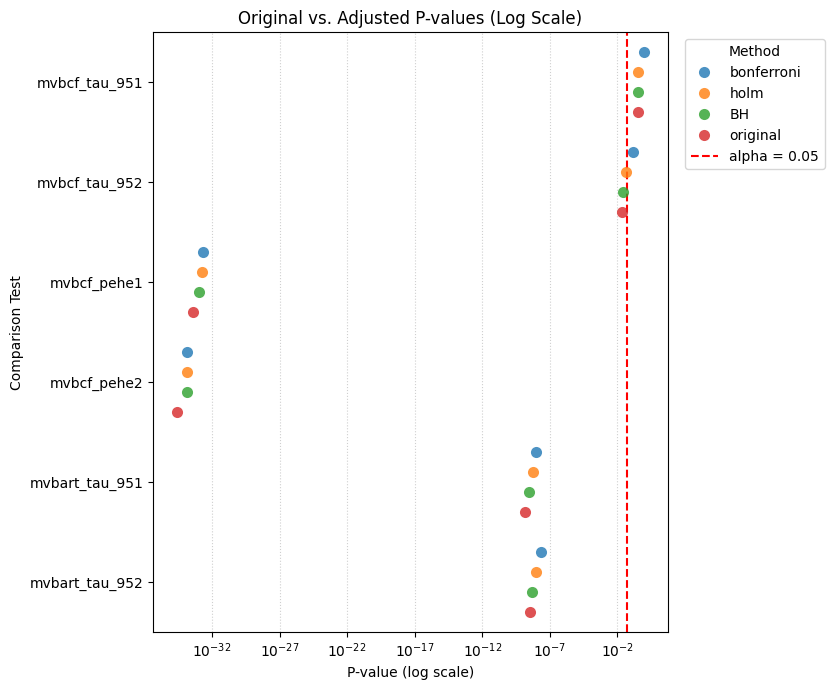

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Need to add original_p to the melted dataframe for easier plotting with hue
results_df_for_dotplot = results_df.copy()
# Create a temporary row for original p-values to plot them
original_rows = results_df_for_dotplot[['comparison', 'original_p']].drop_duplicates()
original_rows['method'] = 'original'
original_rows = original_rows.rename(columns={'original_p': 'p_value'})
original_rows['significant'] = original_rows['p_value'] < alpha # Mark significance for original

# Combine adjusted and original
plot_data = pd.concat([
    results_df_for_dotplot.rename(columns={'adjusted_p': 'p_value'})[['comparison', 'method', 'p_value', 'significant']],
    original_rows
], ignore_index=True)

# Plotting
plt.figure(figsize=(10, 7))
sns.stripplot(data=plot_data, y='comparison', x='p_value', hue='method',
              palette='tab10', dodge=True, size=8, alpha=0.8) # Use dodge=True to separate methods

# Use log scale for p-value axis
plt.xscale('log')
plt.axvline(x=alpha, color='red', linestyle='--', linewidth=1.5, label=f'alpha = {alpha}')

plt.xlabel("P-value (log scale)")
plt.ylabel("Comparison Test")
plt.title("Original vs. Adjusted P-values (Log Scale)")
plt.legend(title='Method', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.grid(True, axis='x', linestyle=':', alpha=0.6)
plt.show()

In [7]:
import pandas as pd
import seaborn as sns

# Prepare data for the table view
table_view = adjusted_p.copy()
table_view.insert(0, 'original', original_p['original_p'])

# Function to color cells based on significance (using the boolean significance table)
def highlight_significant(val, method, comparison_index):
    is_significant = significance.loc[comparison_index, method]
    color = 'background-color: lightgreen' if is_significant else 'background-color: white'
    return color

# Function to create background gradient for p-values (lower p = darker)
cmap = sns.light_palette("lightblue", as_cmap=True, reverse=True) # Darker for smaller values

styled_table = table_view.style \
    .apply(lambda col: [highlight_significant(val, col.name, idx) for idx, val in col.items()],
           subset=['bonferroni', 'holm', 'BH'], axis=0) \
    .background_gradient(cmap=cmap, subset=['original', 'bonferroni', 'holm', 'BH'], axis=None) \
    .format("{:.2e}") \
    .set_caption(f"P-value Comparison (Significant cells highlighted for alpha={alpha})") \
    .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}])

# Display the styled table (works best in environments like Jupyter)
# In a plain script, you might save it to HTML: styled_table.to_html('p_value_table.html')
print("--- Styled Table (HTML representation) ---")
# For display in environments that render HTML:
from IPython.display import display
display(styled_table)
# Or save to file:
# try:
#     styled_table.to_html('styled_p_value_table.html')
#     print("\nStyled table saved to styled_p_value_table.html")
# except Exception as e:
#     print(f"\nCould not save styled table to HTML: {e}")

--- Styled Table (HTML representation) ---


,original,bonferroni,holm,BH
comparison,,,,
mvbcf_tau_951,3.40e-01,1.00e+00,3.40e-01,3.40e-01
mvbcf_tau_952,2.28e-02,1.37e-01,4.55e-02,2.73e-02
mvbcf_pehe1,3.88e-34,2.33e-33,1.94e-33,1.16e-33
mvbcf_pehe2,2.36e-35,1.42e-34,1.42e-34,1.42e-34
mvbart_tau_951,1.51e-09,9.06e-09,6.04e-09,3.02e-09
mvbart_tau_952,3.42e-09,2.05e-08,1.03e-08,5.14e-09


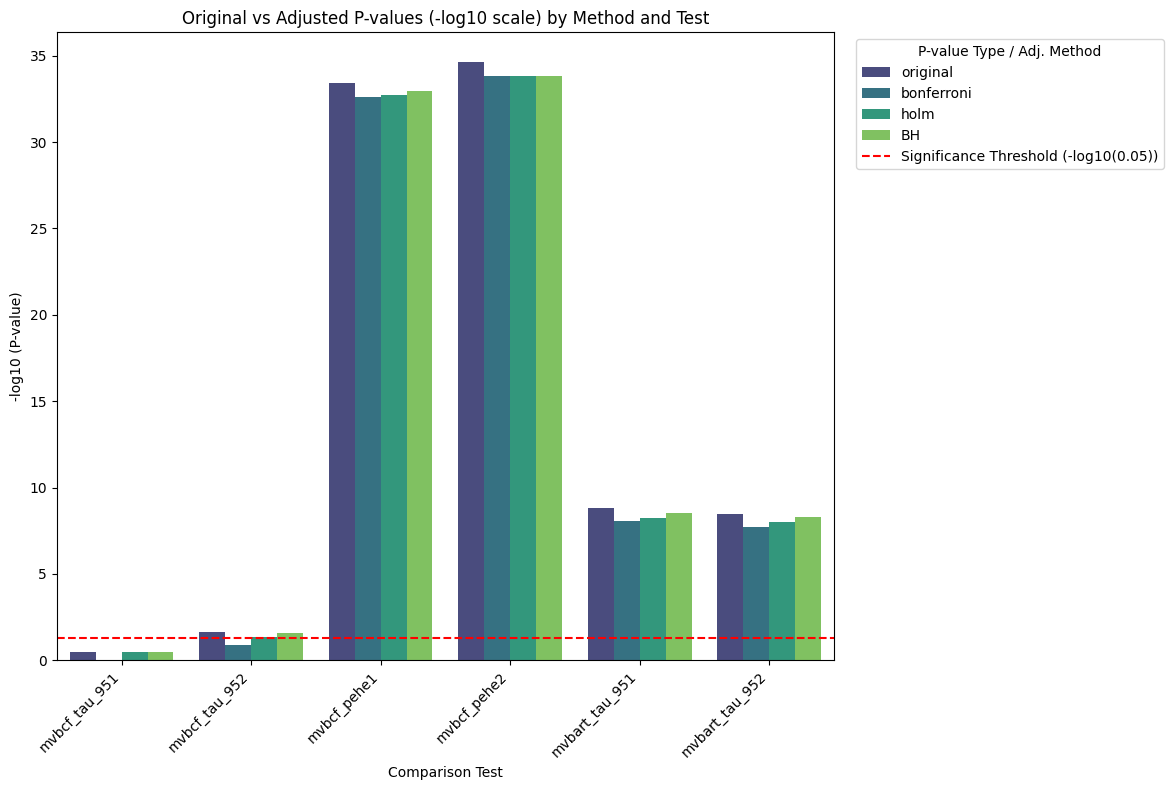

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # Optional: for nice table display in Jupyter

# --- Data Parsing (Assuming this setup from the previous step) ---
# Make sure the parsing code that creates 'results_df', 'original_p',
# 'alpha', and 'neg_log10_alpha' has been run first.

# --- Example Parsing Code (include if needed) ---
original_p_text = """
mvbcf_tau_951_location_welch   3.404376e-01
mvbcf_tau_952_location_welch   2.276454e-02
mvbcf_pehe1_location_welch    3.877277e-34
mvbcf_pehe2_location_welch    2.359128e-35
mvbart_tau_951_location_welch 1.510069e-09
mvbart_tau_952_location_welch 3.424636e-09
"""
adjusted_p_text = """
comparison                       bonferroni          holm            BH
mvbcf_tau_951_location_welch   1.000000e+00  3.404376e-01  3.404376e-01
mvbcf_tau_952_location_welch   1.365872e-01  4.552907e-02  2.731744e-02
mvbcf_pehe1_location_welch    2.326366e-33  1.938638e-33  1.163183e-33
mvbcf_pehe2_location_welch    1.415477e-34  1.415477e-34  1.415477e-34
mvbart_tau_951_location_welch 9.060414e-09  6.040276e-09  3.020138e-09
mvbart_tau_952_location_welch 2.054781e-08  1.027391e-08  5.136954e-09
"""
significance_text = """
comparison                    bonferroni   holm     BH
mvbcf_tau_951_location_welch      FALSE  FALSE  FALSE
mvbcf_tau_952_location_welch      FALSE   TRUE   TRUE
mvbcf_pehe1_location_welch         TRUE   TRUE   TRUE
mvbcf_pehe2_location_welch         TRUE   TRUE   TRUE
mvbart_tau_951_location_welch      TRUE   TRUE   TRUE
mvbart_tau_952_location_welch      TRUE   TRUE   TRUE
"""
original_p = pd.read_csv(io.StringIO(original_p_text), sep='\s+', header=None, index_col=0, names=['comparison', 'original_p'])
adjusted_p = pd.read_csv(io.StringIO(adjusted_p_text), sep='\s+', index_col=0)
significance = pd.read_csv(io.StringIO(significance_text), sep='\s+', index_col=0).astype(bool)
def clean_name(name): return name.replace('_location_welch', '')
original_p.index = original_p.index.map(clean_name)
adjusted_p.index = adjusted_p.index.map(clean_name)
significance.index = significance.index.map(clean_name)
p_val_combined = adjusted_p.melt(ignore_index=False, var_name='method', value_name='adjusted_p').reset_index()
sig_combined = significance.melt(ignore_index=False, var_name='method', value_name='significant').reset_index()
results_df = pd.merge(p_val_combined, sig_combined, on=['comparison', 'method'])
results_df = pd.merge(results_df, original_p.reset_index(), on='comparison')
epsilon = 1e-300
results_df['neg_log10_p'] = -np.log10(results_df['adjusted_p'] + epsilon)
results_df.loc[results_df['adjusted_p'] == 0, 'neg_log10_p'] = 300
alpha = 0.05
neg_log10_alpha = -np.log10(alpha)
# --- End Parsing ---


# --- Prepare data for plotting (including original p-values) ---

# 1. Isolate original p-values, assign 'original' method label, calculate -log10(p)
original_df_part = results_df[['comparison', 'original_p']].drop_duplicates().copy()
original_df_part['method'] = 'original' # Assign a method name
# Calculate -log10 for original p-values
original_df_part['neg_log10_p'] = -np.log10(original_df_part['original_p'] + epsilon)
original_df_part.loc[original_df_part['original_p'] == 0, 'neg_log10_p'] = 300 # Cap if original p was 0
original_df_part = original_df_part[['comparison', 'method', 'neg_log10_p']] # Keep relevant columns

# 2. Get the adjusted p-value part from the existing results_df
adjusted_df_part = results_df[['comparison', 'method', 'neg_log10_p']]

# 3. Combine the original and adjusted dataframes
plot_df_combined = pd.concat([original_df_part, adjusted_df_part], ignore_index=True)

# --- Plotting Code (Modified) ---
plt.figure(figsize=(14, 8)) # Adjusted figure size for more bars

# Define the desired order for the bars within each group
method_order = ['original', 'bonferroni', 'holm', 'BH']

# Use the combined DataFrame and specify the hue_order
sns.barplot(data=plot_df_combined, x='comparison', y='neg_log10_p', hue='method',
            palette='viridis', # You can choose other palettes like 'mako', 'rocket', 'tab10'
            hue_order=method_order) # Ensure 'original' comes first

# Add significance threshold line (applies conceptually to all p-values)
plt.axhline(y=neg_log10_alpha, color='red', linestyle='--', linewidth=1.5,
            label=f'Significance Threshold (-log10({alpha}))')

# --- Customize Plot ---
plt.xlabel("Comparison Test")
plt.ylabel("-log10 (P-value)") # General label now includes original
plt.title("Original vs Adjusted P-values (-log10 scale) by Method and Test") # Updated title
plt.xticks(rotation=45, ha='right') # Rotate labels if they overlap

# Update legend title
plt.legend(title='P-value Type / Adj. Method', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

plt.show()